In [1]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spotpy

In [2]:
# custom imports
import camels_utilities as camels
from sacsma_utilities import run_sacsma, rmse_obj_fun
from optimizer import spotpy_setup

In [3]:
# # this command is executed twice for interactive plotting in Jupyter notebook
# %matplotlib notebook
# %matplotlib notebook

In [4]:
basin = '01054200'

# Load data
parameters = camels.load_sacsma_parameters(basin)
attributes = camels.load_basin_attributes(basin)
forcings, area = camels.load_forcings(basin)
observations = camels.load_usgs(basin, area)
benchmarks = camels.load_discharge(basin)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


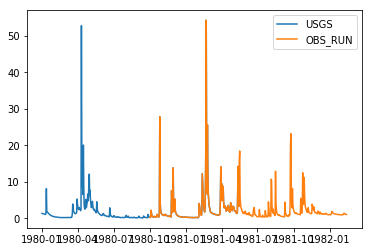

In [5]:
fig = plt.figure()
plt.plot(observations.QObs.iloc[:500], label='USGS')
plt.plot(benchmarks.OBS_RUN.iloc[:500], label='OBS_RUN')
plt.legend()
plt.show()

In [6]:
sac_fluxes, sac_states = run_sacsma(forcings=forcings,
                                    parameters=parameters,
                                    latitude=attributes['gauge_lat'],
                                    elevation=attributes['elev_mean'])

sac_fluxes

,sacsma_pet,sacsma_snow17_raim,sacsma_uh_qq,sacsma_snow17_sneqv,sacsma_snow17_snow,sacsma_snow17_snowh,sacsma_surf,sacsma_grnd,sacsma_qq,sacsma_tet
Date,,,,,,,,,,
1980-01-01,-0.028142,0.000000,231.641983,0.000000,0.0,0.000000,212.029297,19.612690,231.641983,-0.080839
1980-01-02,-0.030082,0.000000,131.199997,0.000000,0.0,0.000000,112.222473,18.977518,131.199997,-0.029931
1980-01-03,-0.013118,0.009180,50.367165,0.000000,0.0,0.000000,32.321926,18.045237,50.367165,-0.013053
1980-01-04,0.003370,0.018360,26.358006,0.000000,0.0,0.000000,9.278199,17.079805,26.358006,0.003353
1980-01-05,0.015235,0.000000,18.775335,0.000000,0.0,0.000000,2.631554,16.143782,18.775335,0.015159
...,...,...,...,...,...,...,...,...,...,...
2014-12-27,-0.069802,0.083459,5.996112,0.015817,0.0,0.048491,3.409278,2.586833,5.996112,-0.069453
2014-12-28,0.020029,16.967937,7.700307,0.012859,0.0,0.036643,5.131092,2.569215,7.700307,0.019929
2014-12-29,-0.024321,0.815457,7.709420,0.012044,0.0,0.036131,5.092207,2.617213,7.709420,-0.024199


In [7]:
# df = pd.concat((sac_fluxes, observations))
df = sac_fluxes['sacsma_uh_qq'].to_frame()
df = df.join(observations['QObs'])
df = df.join(benchmarks.MOD_RUN)
df = df.dropna(axis=0, how='any')
rmse = np.sqrt(np.mean((df.sacsma_uh_qq - df.QObs)**2))
rmse

3.89954995434662

In [8]:
ours_rmse = np.sqrt(np.mean((df.sacsma_uh_qq - observations['QObs'])**2))
ncar_rmse = np.sqrt(np.mean((df.MOD_RUN - observations['QObs'])**2))

print(ours_rmse, ncar_rmse)

3.89954995434662 3.347102042983097


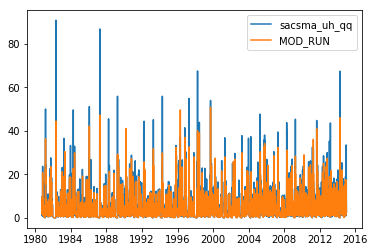

In [9]:
fig = plt.figure()
plt.plot(df['sacsma_uh_qq'], label='sacsma_uh_qq')
plt.plot(df['MOD_RUN'], label='MOD_RUN')
plt.legend()
plt.show()

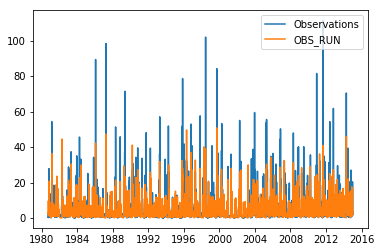

In [10]:
fig = plt.figure()
plt.plot(df['QObs'], label='Observations')
plt.plot(df['MOD_RUN'], label='OBS_RUN')
plt.legend()
plt.show()

In [11]:
rmse = rmse_obj_fun(forcings=forcings,
                    parameters=parameters,
                    observations=observations['QObs'],
                    latitude=attributes['gauge_lat'],
                    elevation=attributes['elev_mean'])

rmse

4.579314239032876

In [18]:
optimizer = spotpy_setup(forcings=forcings,
                         observations=observations['QObs'],
                         latitude=attributes['gauge_lat'],
                         elevation=attributes['elev_mean'],
                         warmup=365)

In [19]:
parms = parameters
parm_vector = parms.loc[optimizer.optimized_parameter_names].values
sim = optimizer.simulation(parm_vector)

In [20]:
rmse = optimizer.objectivefunction(sim, optimizer.evaluation())
rmse

3.907113493992316

In [21]:
sim_df = pd.DataFrame(sim, index=forcings.iloc[365*2:].index)
fig = plt.figure()
plt.plot(sac_fluxes.sacsma_uh_qq, label='sacsma_uh_qq')
plt.plot(benchmarks.MOD_RUN, label='MOD_RUN')
plt.plot(sim_df, label='spotpy')
plt.legend()
plt.show()


ValueError: Shape of passed values is (12419, 1), indices imply (12054, 1)

In [22]:
fig = plt.figure()
plt.scatter(sim_df,sac_fluxes.sacsma_uh_qq, label='sacsma_uh_qq')
# plt.plot(benchmarks.MOD_RUN, label='MOD_RUN')
# plt.plot(sim_df, label='spotpy')
plt.legend()
plt.show()


NameError: name 'sim_df' is not defined

<Figure size 432x288 with 0 Axes>

In [23]:
sampler=spotpy.algorithms.sceua(optimizer, 
                                dbname='SCE', 
                                dbformat='csv')
max_model_runs = 1e5
sampler.sample(max_model_runs, ngs=20)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100000.0  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100000, minimal objective function=5.2911, time remaining: 15:50:17
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'SCE.csv' created.
6 of 100000, minimal objective function=5.2911, time remaining: 19:20:41
12 of 100000, minimal objective function=5.2911, time remaining: 15:15:50
18 of 100000, minimal objective function=5.2911, time remaining: 13:51:09
24 of 100000, minimal objective function=5.2911, time remaining: 13:12:11
29 of 100000, minimal objective function=5.2911, time remaining: 12:51:58
35 of 100000, minimal objective function=5.2911, time remaining: 12:30:18
41 of 100000, minimal objective function=5.2911, time remaining: 12:13:46
47 of 100000, minimal objective function=5.2911, time remaining: 12:00:18
53 of 100000, minimal objective function=5.2911, time remaining: 

KeyboardInterrupt: 

In [ ]:
results = sampler.getdata()
